In [1]:
import pickle
import os
import sys

In [2]:
from collections import defaultdict
from utils.dict_utils import dict_to_defaultdict

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
dataset = 'cifar2'
train_size = 1000
num_hidden = 3
bias = False
normalization = 'none'
optimizer = 'rmsprop'
num_seeds = 5
lr = 0.0001

In [47]:
log_dir = os.path.join(
    'results', 'ref_width_dependence', '{}_{}'.format(dataset, train_size), 
    'num_hidden={}_bias={}_normalization={}'.format(num_hidden, bias, normalization), '{}_lr={}'.format(optimizer, lr))
log_dir

'results/ref_width_dependence/cifar2_1000/num_hidden=3_bias=False_normalization=none/rmsprop_lr=0.0001'

In [48]:
results_all_path = os.path.join(log_dir, 'results_all.dat')
results_all = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: np.nan))))))
if os.path.exists(results_all_path):
    with open(results_all_path, 'rb') as f:
        results_all = dict_to_defaultdict(pickle.load(f), results_all)

In [29]:
scaling_modes = ['default', 'mean_field', 'ntk', 'mean_field_init_corrected', 'intermediate_q=0.75', 'linearized']
ref_widths = [32, 512, 8192, 2**15]
correction_epochs = [0]
real_widths = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

In [30]:
plt.rcParams.update({'font.size': 14})

In [31]:
def draw_curve(scaling_mode, ref_width, correction_epoch, key, idx=None, **kwargs):
    if idx is None:
        data = [
            [
                results_all[scaling_mode][ref_width][correction_epoch][real_width][seed][key] 
                for real_width in real_widths
            ] for seed in range(num_seeds)
        ]
    else:
        data = [
            [
                results_all[scaling_mode][ref_width][correction_epoch][real_width][seed][key][idx][0]
                for real_width in real_widths
            ] for seed in range(num_seeds)
        ]
    data = np.array(data)
    data = np.clip(data, -10, 10)
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(np.log2(real_widths), data_mean, **kwargs)
    plt.fill_between(
        np.log2(real_widths),
        data_mean - data_std, data_mean + data_std,
        alpha=0.3, **kwargs
    )

In [54]:
linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (0,(1,10))]
cmap = plt.get_cmap('tab10')
keys = ['final_test_loss', 'final_test_acc', 'final_train_loss', 'final_train_acc']
ylims = [(0.3,1.5), (0.75, 0.95), (0.0,0.3), (0.9, 1.0)]

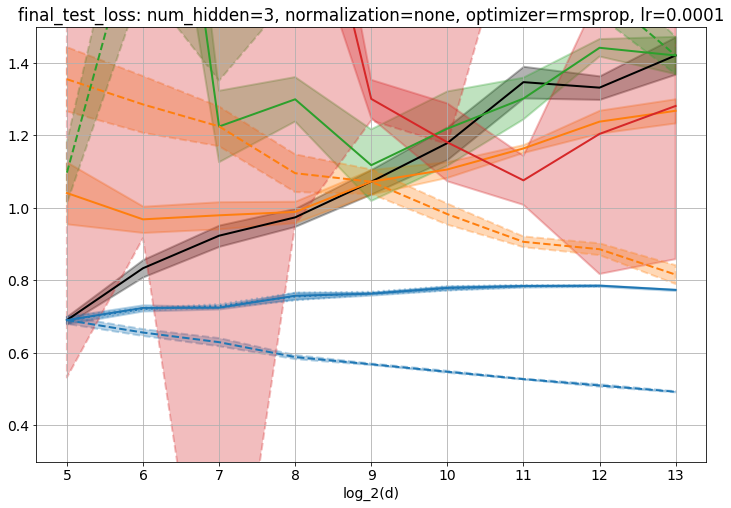

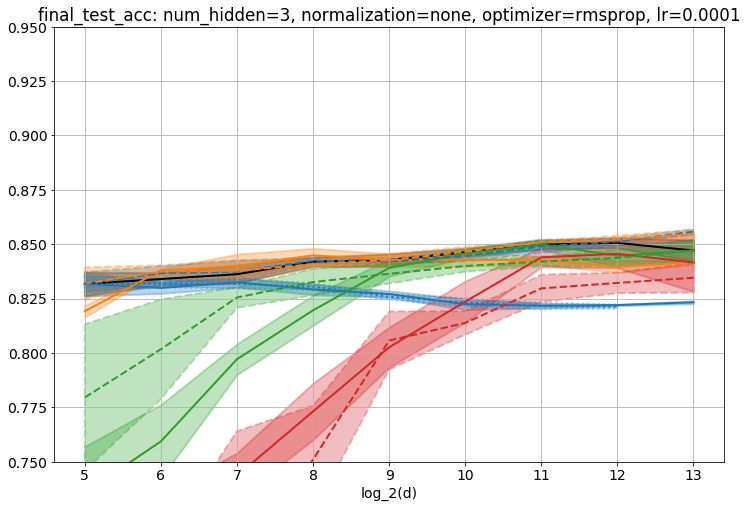

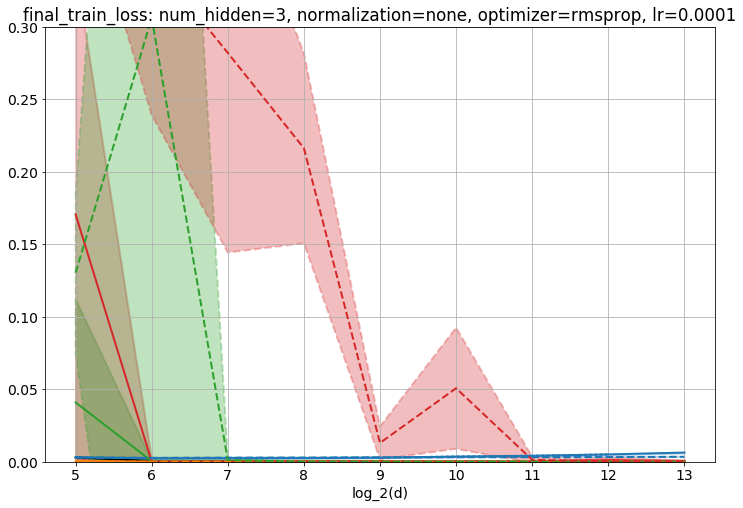

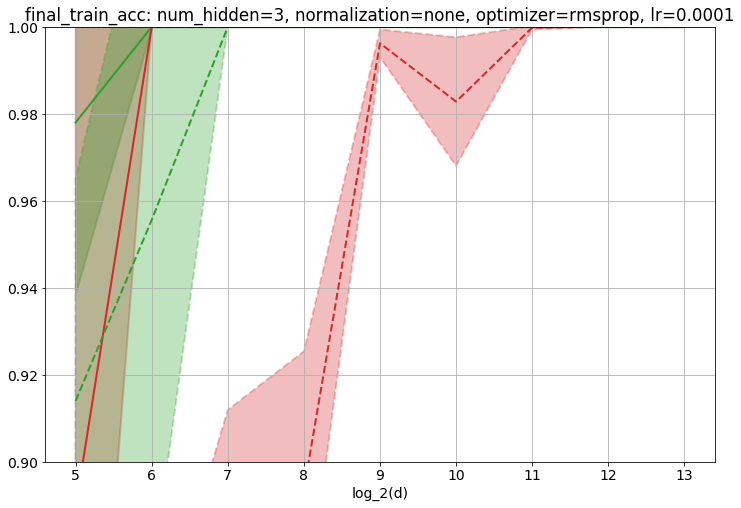

In [55]:
#print(1, file=sys.stderr)
for key, ylim in zip(keys, ylims):
 #   print(2, file=sys.stderr)
    _ = plt.figure(figsize=(12,8))
  #  print(3, file=sys.stderr)

    plt.title(
        '{}: num_hidden={}, normalization={}, optimizer={}, lr={}'.format(
            key, num_hidden, normalization, optimizer, lr
        )
    )
    
    plt.xlabel("log_2(d)")
    plt.ylim(ylim)
    plt.grid(True)

   # print(4, file=sys.stderr)
    for k, scaling_mode in enumerate(scaling_modes):
    #    print(scaling_mode, file=sys.stderr)
        for i, ref_width in enumerate(ref_widths if scaling_mode != 'default' else [None]):
     #       print(ref_width, file=sys.stderr)
            for j, correction_epoch in enumerate(
                correction_epochs if scaling_mode.startswith('mean_field') else [None]
            ):
                if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                    continue
      #          print(correction_epoch, file=sys.stderr)
                if scaling_mode == 'default':
                    draw_curve(scaling_mode, ref_width, correction_epoch, key, color='black', linestyle='solid', linewidth=2)
                else:
                    draw_curve(
                        scaling_mode, ref_width, correction_epoch, key, color=cmap(i), 
                        linestyle=linestyles[k-1], linewidth=2+j
                    )
                    
#     plt.legend(
#         ['reference: d*=d'] + [
#             '{}: d*={}'.format(scaling_mode, ref_width) 
#             for scaling_mode in scaling_modes[1:] for ref_width in ref_widths
#         ]
#     )
    plt.show()

In [55]:
linestyles = ['solid', 'dashed', 'dotted', 'dashdot']
cmap = plt.get_cmap('tab10')
keys = ['final_logits']
indices = [0,1,2,3]
ylims = [(-2,2)] * len(indices)

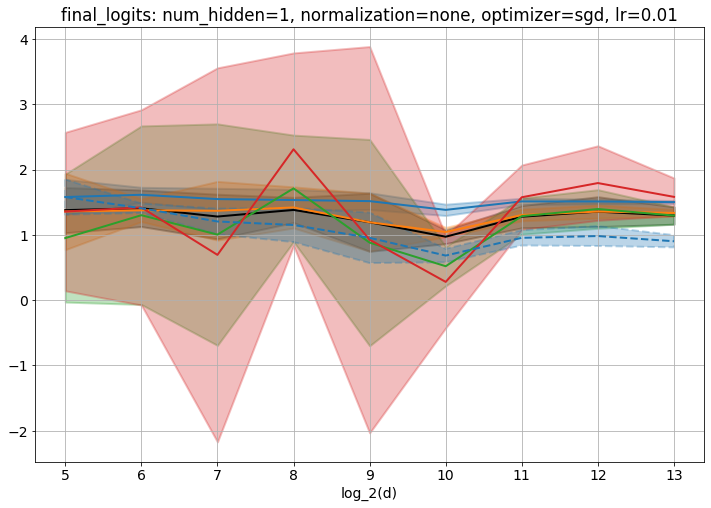

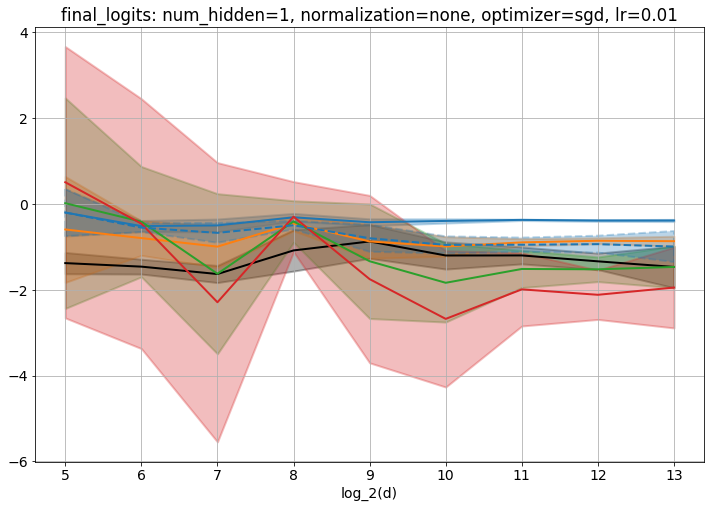

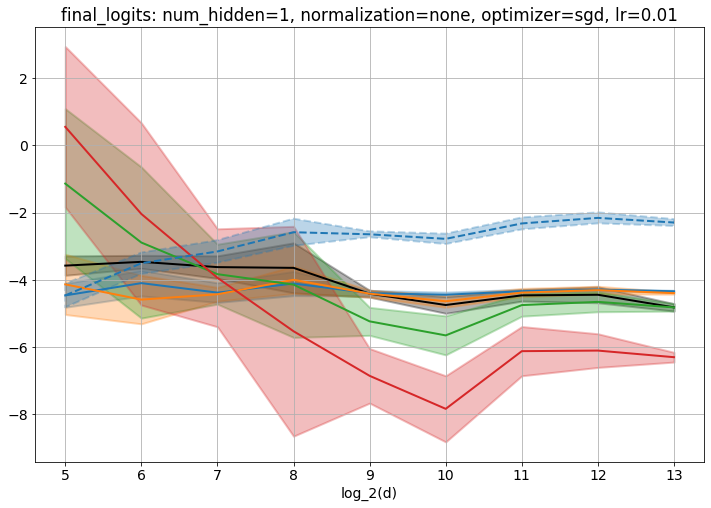

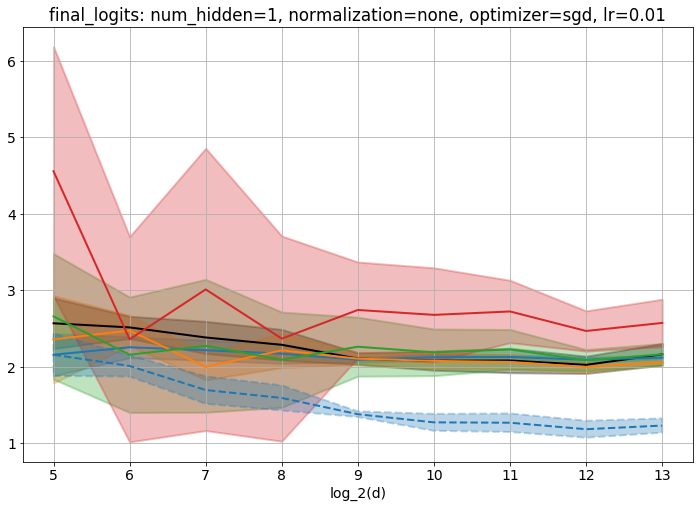

In [58]:
for key in keys:
    for idx, ylim in zip(indices, ylims):
        _ = plt.figure(figsize=(12,8))

        plt.title(
            '{}: num_hidden={}, normalization={}, optimizer={}, lr={}'.format(
                key, num_hidden, normalization, optimizer, lr
            )
        )

        plt.xlabel("log_2(d)")
        #plt.ylim(ylim)
        plt.grid(True)

        for k, scaling_mode in enumerate(scaling_modes):
            for i, ref_width in enumerate(ref_widths if scaling_mode != 'default' else [None]):
                for j, correction_epoch in enumerate(
                    correction_epochs if scaling_mode.startswith('mean_field') else [None]
                ):
                    #print(k,i,j)
                    if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                        continue
                    try:
                        if scaling_mode == 'default':
                            draw_curve(
                                scaling_mode, ref_width, correction_epoch, key, idx=idx, 
                                color='black', linestyle='solid', linewidth=2
                            )
                        else:
                            draw_curve(
                                scaling_mode, ref_width, correction_epoch, key, idx=idx, 
                                color=cmap(i), linestyle=linestyles[k-1], linewidth=2+j
                            )
                    except TypeError:
                        pass

    #     plt.legend(
    #         ['reference: d*=d'] + [
    #             '{}: d*={}'.format(scaling_mode, ref_width) 
    #             for scaling_mode in scaling_modes[1:] for ref_width in ref_widths
    #         ]
    #     )
        plt.show()